## Import libraries

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt

## Get data

I'm going to use the historical price data of Bitcoin to try and predict the future price of Bitcoin!

The data was procured from the CoinDesk website located at: https://coindesk.com/price/bitcoin.

In [2]:
!wget https://raw.githubusercontent.com/NegreaAlexandruCristian/Lucrare-Dizertatie-ML/main/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-03-28 11:51:16--  https://raw.githubusercontent.com/NegreaAlexandruCristian/Lucrare-Dizertatie-ML/main/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175721 (172K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 171.60K  --.-KB/s    in 0.02s   

2023-03-28 11:51:16 (7.66 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [175721/175721]



## Importing time series with pandas since it's a library that can read csv data directly and create a DataFrame

In [3]:
# Read our Bitcoin data and parse the data

timesteps = []
btc_prices = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_prices.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_prices[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

In [4]:
# Visualize our data as a dataframe
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # prase the date column and tell pandas column 1 is a datetime 

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [5]:
# Get info about our data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [6]:
# Now let's see how many data samples that we have
len(df)

2787

I've collected the historical price of Bitcoin for the past 8 years (aproximately) but there are only 2787 samples.

A smaller number of samples is something that is normal when dealing with time series data problems. The term to better describe this is seasonality.

**Note:** Seasonality means that a time series dataset is reffered as the number of samples per year. So for this Bitcoin data, it has a seasonlity of daily or value of 365 because I'm collecting one sample per day meaning I'm getting 365 samples per year.

More about this can be found here: https://otexts.com/fpp3/tspatterns.html

In [7]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


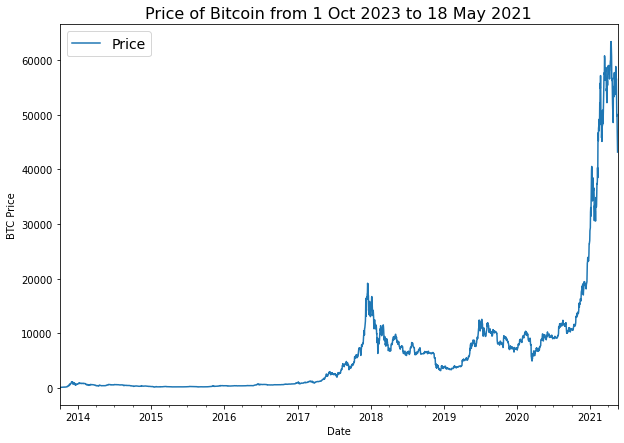

In [8]:
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2023 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14)

## Format data: Create train and test sets of the time series data above

In [9]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [10]:
# Create train and test splits
split_size = int(0.8 * len(prices)) # 80% train and 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

In [11]:
# Create function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of plot in time) against values (a series of values across timesteps)

  Parameters
  ----------
  timesteps: array of timesteps values
  values: array of values across time
  format: style of plot, defaul "."
  start: where to start the plot (setting a value will index from start of timesteps & values)
  end: where to end the plot (similar to start but for the end)
  label: label to show on plot about values, default None
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

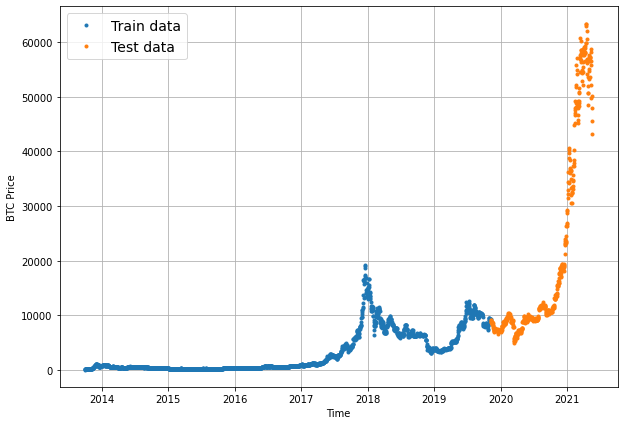

In [12]:
# Plot made splits
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

I will run several modelling experiments to see which one performs the best.

Terms to be familiar with:

* Horizon = number of timesteps into the future we're going to predict
* Window size = number of timesteps we're going to use to predict horizon

Modelling experiments I'll be running:

* 0 Naive model (baseline)
* 1 Dense model, horizon = 1, window = 7
* 2 Same as 1, horizon = 1, window = 30
* 3 Same as 1, horizon = 7, window = 30
* 4 Conv1D
* 5 LSTM
* 6 Same as 1 (but with multivariate data)
* 7 N-BEATs Algorithm
* 8 Ensemble (multiple models optimized on different loss functions)
* 9 Future prediction model (model to predict future values)
* 10 Same as 1 (but with turkey 🦃 data introduced)

## Model 0: Naive forecast model (the baseline)
More info here: https://otexts.com/fpp3/simple-methods.html

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

The prediction at timestep t (the y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1

In [13]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[:-10]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([ 9226.48582088,  8794.35864452,  8798.04205463,  9081.18687849,
         8711.53433917,  8760.89271814,  8749.52059102,  8656.97092235,
         8500.64355816,  8469.2608989 ,  8537.33965197,  8205.80636599,
         8118.4885358 ,  8074.84317361,  7612.7405735 ,  7262.11053495,
         7303.40575852,  7041.73293642,  7211.86180875,  7141.06944869,
         7523.4806726 ,  7390.20746923,  7729.26593894,  7542.23560864,
         7381.96300782,  7333.43293049,  7315.36776456,  7213.73376172,
         7398.78704961,  7511.88058312,  7532.12351309,  7550.23919987,
         7333.09604316,  7239.76257544,  7198.06667705,  7190.27236926,
         7238.87432299,  7087.02498535,  7112.73147612,  6883.49639377,
         6584.02884335,  7424.01540023,  7147.56832379,  7139.93337053,
         7286.33508116,  7236.98

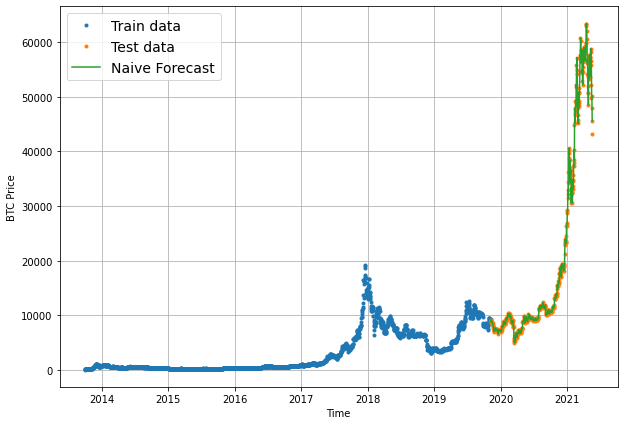

In [14]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive Forecast")

## Evaluating a time series model

I'm predicting a number, so that means I have a form of regression problem.

Because it is a regression problem, I'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, lower is better, for example, an MAE of 0 that is better than an MAE of 100.

The main thing that I'm evaluating here is: how the model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?

In [15]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mea_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]- y_true[:-1])) # our seasonality is 1 day (hence the shift is 1)
  
  return mae / mea_naive_no_season

In [16]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [17]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatyep (for metric calculations)
  y_true - tf.cast(y_true, dtype=tf.float64)
  y_pred = tf.cast(y_pred, dtype=tf.float64)

  # Calculate various evaluation metrcs#
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for diffrent size metrics (for longer horizons, we want to reduce metrics to a singular value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {
      "mae": mae.numpy(),
      "mse": mse.numpy(),
      "rmse": rmse.numpy(),
      "mape": mape.numpy(),
      "mase": mase.numpy()
  }

In [18]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 567.9802273457541,
 'mse': 1147547.125023896,
 'rmse': 1071.2362601330744,
 'mape': 2.516524929982267,
 'mase': 0.9995699939182624}

## Window the dataset

I need to window the serues dataset to turn the data into a supervised learning problem.

```
Ex:
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [19]:
bitcoin_prices["Price"][:7]

Date
2013-10-01    123.65499
2013-10-02    125.45500
2013-10-03    108.58483
2013-10-04    118.67466
2013-10-05    121.33866
2013-10-06    120.65533
2013-10-07    121.79500
Name: Price, dtype: float64

In [20]:
# What I want to do with the Bitcoin data
print(f"I want to use this: {btc_prices[:7]} to predict this: {btc_prices[7]}")

I want to use this: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [21]:
# Global variables for window and horizon size
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use the past week of bitcoin data to make the prediction

In [22]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [23]:
# Test out the windows labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8) + 1, axis=0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]], dtype=int32)>)

In [24]:
# Create function to view numpy arrays as windows by following this article:
# https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """

  # Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  # Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon -1)), axis=0).T # create 2D array of windows of size window_size

  # Index on the target array (a time series) with 2D array of multiple window steps
  window_array = x[window_indexes]

  # Get the labelled windows
  windows, labels = get_labelled_windows(window_array, horizon=horizon)
  return windows, labels

In [25]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(2780, 2780)

In [26]:
# View the first 3 windwos/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [27]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


## Turning windows into training and test sets

In [28]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Split matching pairs of windows and labels into train and test splits
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [29]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [30]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [31]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [32]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

In [33]:
train_labels[:5].shape

(5, 1)

## Make a modelling checkpoint callback

Because the model's performance will flactuate from experiment to experiment I need to write a model checkpoint so that I can compare a model's performance to anothers.

For example, if the model performs the best on epoch 55 out of 100, I would like to save the model's performance and weights on that checkpoint.

In [34]:
# Create a function to implement a ModelCheckoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(
      filepath=os.path.join(save_path, model_name),
      verbosity=0, # only output a limited amount of text
      save_best_only=True
  )

## Model 1: Dense model (window = 7, horizon = 1)

The first deep model is going to be a simple dense model and is going to have the following parameters:

* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizaiton and MAE loss function
* Batch size of 128
* 100 epochs

Those parameters are picked to experiment and test this model to see it's performance.

In [35]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct the model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense")

# Compile the model
model_1.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_1.fit(
    x = train_windows,
    y = train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name="model_1_name")]
)

Epoch 1/100
 1/18 [>.............................] - ETA: 14s - loss: 4081.1096 - mae: 4081.1096 - mse: 34219896.0000

18/18 [==============================] - 2s 55ms/step - loss: 1930.0029 - mae: 1930.0029 - mse: 11723241.0000 - val_loss: 1100.6790 - val_mae: 1100.6790 - val_mse: 3818298.5000
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 379.1212 - mae: 379.1212 - mse: 534480.0625 - val_loss: 1954.4121 - val_mae: 1954.4121 - val_mse: 8569577.0000
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 221.4410 - mae: 221.4410 - mse: 226786.8906 - val_loss: 1153.6217 - val_mae: 1153.6217 - val_mse: 3573755.2500
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 214.4111 - mae: 214.4111 - mse: 169186.9531

18/18 [==============================] - 1s 31ms/step - loss: 172.7508 - mae: 172.7508 - mse: 150175.3438 - val_loss: 961.0180 - val_mae: 961.0181 - val_mse: 2798133.0000
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 154.2889 - mae: 154.2889 - mse: 87065.7734

18/18 [==============================] - 1s 34ms/step - loss: 160.4265 - mae: 160.4265 - mse: 139933.8281 - val_loss: 864.2540 - val_mae: 864.2540 - val_mse: 2475489.0000
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 115.4170 - mae: 115.4170 - mse: 56167.3750

18/18 [==============================] - 1s 33ms/step - loss: 155.9008 - mae: 155.9008 - mse: 130267.8828 - val_loss: 843.8029 - val_mae: 843.8029 - val_mse: 2379203.2500
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 183.8383 - mae: 183.8383 - mse: 251813.0938

18/18 [==============================] - 1s 33ms/step - loss: 149.0361 - mae: 149.0361 - mse: 120937.0469 - val_loss: 830.8336 - val_mae: 830.8336 - val_mse: 2221621.5000
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 127.0507 - mae: 127.0507 - mse: 65971.6406

18/18 [==============================] - 1s 33ms/step - loss: 146.1909 - mae: 146.1909 - mse: 117499.5703 - val_loss: 799.3668 - val_mae: 799.3668 - val_mse: 2130903.2500
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 144.9680 - mae: 144.9680 - mse: 116082.2734 - val_loss: 837.3987 - val_mae: 837.3987 - val_mse: 2131047.2500
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 153.2370 - mae: 153.2370 - mse: 154688.6250

18/18 [==============================] - 1s 34ms/step - loss: 142.2166 - mae: 142.2166 - mse: 111992.4297 - val_loss: 777.0284 - val_mae: 777.0284 - val_mse: 1944832.0000
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 143.4189 - mae: 143.4189 - mse: 96685.6562

18/18 [==============================] - 1s 32ms/step - loss: 139.7705 - mae: 139.7705 - mse: 106379.9375 - val_loss: 750.9100 - val_mae: 750.9100 - val_mse: 1892056.1250
Epoch 12/100
18/18 [==============================] - 0s 4ms/step - loss: 135.4548 - mae: 135.4548 - mse: 102392.5391 - val_loss: 803.1526 - val_mae: 803.1526 - val_mse: 1955008.8750
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 114.9103 - mae: 114.9103 - mse: 76358.3828

18/18 [==============================] - 1s 49ms/step - loss: 135.4812 - mae: 135.4812 - mse: 102518.1328 - val_loss: 728.5370 - val_mae: 728.5370 - val_mse: 1735866.1250
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 136.0924 - mae: 136.0924 - mse: 86210.3672

18/18 [==============================] - 1s 46ms/step - loss: 130.6300 - mae: 130.6300 - mse: 96595.2422 - val_loss: 727.9734 - val_mae: 727.9734 - val_mse: 1710151.6250
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 129.0414 - mae: 129.0414 - mse: 62596.3711

18/18 [==============================] - 1s 47ms/step - loss: 130.8903 - mae: 130.8903 - mse: 94841.5234 - val_loss: 709.2991 - val_mae: 709.2991 - val_mse: 1651059.6250
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 112.9736 - mae: 112.9736 - mse: 57185.8320

18/18 [==============================] - 1s 45ms/step - loss: 127.6057 - mae: 127.6057 - mse: 92101.1094 - val_loss: 707.7447 - val_mae: 707.7447 - val_mse: 1630968.8750
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 114.5917 - mae: 114.5917 - mse: 60788.9297

18/18 [==============================] - 1s 33ms/step - loss: 125.9128 - mae: 125.9128 - mse: 90486.0469 - val_loss: 702.3561 - val_mae: 702.3561 - val_mse: 1605611.0000
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 140.1261 - mae: 140.1261 - mse: 99906.3359

18/18 [==============================] - 1s 33ms/step - loss: 125.7993 - mae: 125.7993 - mse: 89697.0469 - val_loss: 673.0236 - val_mae: 673.0236 - val_mse: 1532699.1250
Epoch 19/100
18/18 [==============================] - 0s 4ms/step - loss: 124.7686 - mae: 124.7686 - mse: 89111.1875 - val_loss: 683.9926 - val_mae: 683.9926 - val_mse: 1543519.1250
Epoch 20/100
18/18 [==============================] - 0s 4ms/step - loss: 123.1198 - mae: 123.1198 - mse: 88124.1953 - val_loss: 685.7073 - val_mae: 685.7073 - val_mse: 1540533.1250
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 134.5196 - mae: 134.5196 - mse: 78345.0234

18/18 [==============================] - 1s 33ms/step - loss: 125.2603 - mae: 125.2603 - mse: 87921.9453 - val_loss: 655.0529 - val_mae: 655.0529 - val_mse: 1480256.0000
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 180.1559 - mae: 180.1559 - mse: 181094.8438

18/18 [==============================] - 1s 32ms/step - loss: 122.9334 - mae: 122.9334 - mse: 87359.4844 - val_loss: 650.5670 - val_mae: 650.5670 - val_mse: 1449005.1250
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 131.1017 - mae: 131.1017 - mse: 75754.5312

18/18 [==============================] - 1s 33ms/step - loss: 122.1401 - mae: 122.1401 - mse: 86012.4766 - val_loss: 649.8763 - val_mae: 649.8763 - val_mse: 1439619.7500
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 132.0215 - mae: 132.0215 - mse: 88656.8281

18/18 [==============================] - 1s 33ms/step - loss: 121.8056 - mae: 121.8056 - mse: 86042.3828 - val_loss: 641.5279 - val_mae: 641.5279 - val_mse: 1417805.1250
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 133.3963 - mae: 133.3963 - mse: 73172.4375

18/18 [==============================] - 1s 31ms/step - loss: 120.4524 - mae: 120.4524 - mse: 83753.3281 - val_loss: 637.6651 - val_mae: 637.6651 - val_mse: 1402945.0000
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 121.5423 - mae: 121.5423 - mse: 70486.7500

18/18 [==============================] - 1s 34ms/step - loss: 119.7377 - mae: 119.7377 - mse: 82535.0469 - val_loss: 637.0922 - val_mae: 637.0922 - val_mse: 1412701.2500
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 168.8034 - mae: 168.8034 - mse: 138903.6250

18/18 [==============================] - 1s 31ms/step - loss: 121.0413 - mae: 121.0413 - mse: 83626.0703 - val_loss: 631.4589 - val_mae: 631.4589 - val_mse: 1378818.0000
Epoch 28/100
18/18 [==============================] - 0s 4ms/step - loss: 118.9336 - mae: 118.9336 - mse: 81075.5938 - val_loss: 631.5069 - val_mae: 631.5069 - val_mse: 1371328.2500
Epoch 29/100
18/18 [==============================] - 0s 5ms/step - loss: 116.9380 - mae: 116.9380 - mse: 80110.2812 - val_loss: 643.6401 - val_mae: 643.6401 - val_mse: 1392539.6250
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 135.9435 - mae: 135.9435 - mse: 92843.6406

18/18 [==============================] - 1s 50ms/step - loss: 121.9978 - mae: 121.9978 - mse: 83524.9375 - val_loss: 623.3704 - val_mae: 623.3704 - val_mse: 1356605.6250
Epoch 31/100
18/18 [==============================] - 0s 4ms/step - loss: 116.9917 - mae: 116.9917 - mse: 78215.2266 - val_loss: 627.9684 - val_mae: 627.9684 - val_mse: 1348549.7500
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 109.6021 - mae: 109.6021 - mse: 78827.5312

18/18 [==============================] - 1s 34ms/step - loss: 116.7140 - mae: 116.7140 - mse: 79950.7500 - val_loss: 621.3505 - val_mae: 621.3505 - val_mse: 1332426.3750
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 117.0420 - mae: 117.0420 - mse: 79392.2266 - val_loss: 638.5681 - val_mae: 638.5681 - val_mse: 1364102.2500
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 132.2393 - mae: 132.2393 - mse: 114332.9922

18/18 [==============================] - 1s 33ms/step - loss: 117.9245 - mae: 117.9245 - mse: 80633.0938 - val_loss: 618.9603 - val_mae: 618.9603 - val_mse: 1342302.3750
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 103.9871 - mae: 103.9871 - mse: 58223.0391

18/18 [==============================] - 1s 32ms/step - loss: 114.8765 - mae: 114.8765 - mse: 77747.8672 - val_loss: 610.7809 - val_mae: 610.7809 - val_mse: 1302806.5000
Epoch 36/100
18/18 [==============================] - 0s 4ms/step - loss: 122.1556 - mae: 122.1556 - mse: 81440.3750 - val_loss: 642.2667 - val_mae: 642.2667 - val_mse: 1364146.3750
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 143.9196 - mae: 143.9196 - mse: 116056.9531

18/18 [==============================] - 1s 32ms/step - loss: 116.6857 - mae: 116.6857 - mse: 78954.3438 - val_loss: 606.7650 - val_mae: 606.7650 - val_mse: 1295132.5000
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 101.6229 - mae: 101.6229 - mse: 66308.2969

18/18 [==============================] - 1s 32ms/step - loss: 116.6817 - mae: 116.6817 - mse: 77636.4062 - val_loss: 606.3564 - val_mae: 606.3564 - val_mse: 1294671.6250
Epoch 39/100
18/18 [==============================] - 0s 5ms/step - loss: 113.6721 - mae: 113.6721 - mse: 76113.5781 - val_loss: 607.4514 - val_mae: 607.4514 - val_mse: 1283346.1250
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 107.0250 - mae: 107.0250 - mse: 105786.9141

18/18 [==============================] - 1s 39ms/step - loss: 112.6993 - mae: 112.6993 - mse: 75255.2656 - val_loss: 602.2383 - val_mae: 602.2383 - val_mse: 1279866.8750
Epoch 41/100
18/18 [==============================] - 0s 6ms/step - loss: 112.8346 - mae: 112.8346 - mse: 75606.3594 - val_loss: 621.4663 - val_mae: 621.4663 - val_mse: 1335862.7500
Epoch 42/100
18/18 [==============================] - 0s 7ms/step - loss: 117.3702 - mae: 117.3702 - mse: 79232.0703 - val_loss: 611.7750 - val_mae: 611.7750 - val_mse: 1279268.2500
Epoch 43/100
18/18 [==============================] - 0s 7ms/step - loss: 114.6305 - mae: 114.6305 - mse: 74393.3828 - val_loss: 645.2520 - val_mae: 645.2520 - val_mse: 1387476.7500
Epoch 44/100
16/18 [=========================>....] - ETA: 0s - loss: 114.5322 - mae: 114.5322 - mse: 76853.6484

18/18 [==============================] - 1s 47ms/step - loss: 114.5197 - mae: 114.5197 - mse: 75765.0703 - val_loss: 599.8522 - val_mae: 599.8522 - val_mse: 1253024.7500
Epoch 45/100
12/18 [===================>..........] - ETA: 0s - loss: 109.8743 - mae: 109.8743 - mse: 71286.8281

18/18 [==============================] - 1s 50ms/step - loss: 111.5623 - mae: 111.5623 - mse: 74991.3438 - val_loss: 593.5036 - val_mae: 593.5036 - val_mse: 1253005.0000
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 112.4122 - mae: 112.4122 - mse: 74382.5000 - val_loss: 603.6410 - val_mae: 603.6410 - val_mse: 1258060.1250
Epoch 47/100
18/18 [==============================] - 0s 7ms/step - loss: 114.2390 - mae: 114.2390 - mse: 76198.8203 - val_loss: 634.2230 - val_mae: 634.2230 - val_mse: 1323401.0000
Epoch 48/100
18/18 [==============================] - 0s 6ms/step - loss: 112.2421 - mae: 112.2421 - mse: 75247.0000 - val_loss: 628.6639 - val_mae: 628.6639 - val_mse: 1306332.5000
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 114.4748 - mae: 114.4748 - mse: 75965.8594 - val_loss: 611.6317 - val_mae: 611.6317 - val_mse: 1268691.3750
Epoch 50/100
 1/18 [>.............................] - ETA: 0s - loss: 133.9324 - mae: 133.9324 - mse: 

18/18 [==============================] - 1s 31ms/step - loss: 117.1314 - mae: 117.1314 - mse: 76513.2188 - val_loss: 586.2843 - val_mae: 586.2843 - val_mse: 1231764.3750
Epoch 51/100
18/18 [==============================] - 0s 4ms/step - loss: 111.8446 - mae: 111.8446 - mse: 74260.6875 - val_loss: 621.0958 - val_mae: 621.0958 - val_mse: 1286575.2500
Epoch 52/100
18/18 [==============================] - 0s 4ms/step - loss: 117.9028 - mae: 117.9028 - mse: 79211.7422 - val_loss: 639.0108 - val_mae: 639.0108 - val_mse: 1354554.1250
Epoch 53/100
 1/18 [>.............................] - ETA: 0s - loss: 67.9077 - mae: 67.9077 - mse: 25383.0977

18/18 [==============================] - 1s 36ms/step - loss: 120.4118 - mae: 120.4118 - mse: 78872.1250 - val_loss: 582.8904 - val_mae: 582.8904 - val_mse: 1215363.8750
Epoch 54/100
18/18 [==============================] - 0s 4ms/step - loss: 115.5734 - mae: 115.5734 - mse: 75786.3203 - val_loss: 655.1899 - val_mae: 655.1899 - val_mse: 1361063.8750
Epoch 55/100
18/18 [==============================] - 0s 5ms/step - loss: 113.3264 - mae: 113.3264 - mse: 74858.5781 - val_loss: 602.7822 - val_mae: 602.7822 - val_mse: 1244153.0000
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 113.9844 - mae: 113.9844 - mse: 74209.2188 - val_loss: 855.1179 - val_mae: 855.1179 - val_mse: 2064853.0000
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 144.8854 - mae: 144.8854 - mse: 99797.2812 - val_loss: 657.5737 - val_mae: 657.5737 - val_mse: 1397035.0000
Epoch 58/100
18/18 [==============================] - 0s 4ms/step - loss: 122.9027 - mae: 122.9027 - m

18/18 [==============================] - 1s 32ms/step - loss: 110.9445 - mae: 110.9445 - mse: 72083.1016 - val_loss: 582.4991 - val_mae: 582.4991 - val_mse: 1217454.7500
Epoch 60/100
18/18 [==============================] - 0s 5ms/step - loss: 110.8643 - mae: 110.8643 - mse: 73042.7969 - val_loss: 599.3265 - val_mae: 599.3265 - val_mse: 1232012.6250
Epoch 61/100
 1/18 [>.............................] - ETA: 0s - loss: 136.5215 - mae: 136.5215 - mse: 104193.7812

18/18 [==============================] - 1s 48ms/step - loss: 109.8700 - mae: 109.8700 - mse: 72128.6719 - val_loss: 575.3452 - val_mae: 575.3452 - val_mse: 1195451.1250
Epoch 62/100
18/18 [==============================] - 0s 4ms/step - loss: 108.3411 - mae: 108.3411 - mse: 70991.9141 - val_loss: 577.0437 - val_mae: 577.0437 - val_mse: 1201053.6250
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 112.5022 - mae: 112.5022 - mse: 73394.2500 - val_loss: 615.2595 - val_mae: 615.2595 - val_mse: 1263482.1250
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 110.9626 - mae: 110.9626 - mse: 72256.6797 - val_loss: 581.1816 - val_mae: 581.1816 - val_mse: 1201474.8750
Epoch 65/100
 1/18 [>.............................] - ETA: 0s - loss: 128.6538 - mae: 128.6538 - mse: 160031.9219

18/18 [==============================] - 1s 32ms/step - loss: 109.0926 - mae: 109.0926 - mse: 71594.4219 - val_loss: 574.2986 - val_mae: 574.2986 - val_mse: 1192895.7500
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 114.4958 - mae: 114.4958 - mse: 80262.9609

18/18 [==============================] - 1s 32ms/step - loss: 108.4433 - mae: 108.4433 - mse: 71154.0078 - val_loss: 573.1792 - val_mae: 573.1792 - val_mse: 1187634.6250
Epoch 67/100
18/18 [==============================] - 0s 4ms/step - loss: 107.9386 - mae: 107.9386 - mse: 70048.3984 - val_loss: 613.9647 - val_mae: 613.9647 - val_mse: 1277332.3750
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 114.9908 - mae: 114.9908 - mse: 70683.1328 - val_loss: 693.3065 - val_mae: 693.3065 - val_mse: 1486864.3750
Epoch 69/100
18/18 [==============================] - 0s 4ms/step - loss: 122.2882 - mae: 122.2882 - mse: 78833.0859 - val_loss: 577.9659 - val_mae: 577.9659 - val_mse: 1204613.1250
Epoch 70/100
18/18 [==============================] - 0s 4ms/step - loss: 129.1749 - mae: 129.1749 - mse: 83996.2266 - val_loss: 579.1875 - val_mae: 579.1875 - val_mse: 1197009.1250
Epoch 71/100
18/18 [==============================] - 0s 4ms/step - loss: 115.0380 - mae: 115.0380 - m

18/18 [==============================] - 1s 31ms/step - loss: 109.9112 - mae: 109.9112 - mse: 71864.0156 - val_loss: 569.5914 - val_mae: 569.5914 - val_mse: 1177122.8750
Epoch 77/100
18/18 [==============================] - 0s 4ms/step - loss: 108.5421 - mae: 108.5421 - mse: 70528.1172 - val_loss: 571.1583 - val_mae: 571.1583 - val_mse: 1186723.5000
Epoch 78/100
18/18 [==============================] - 0s 4ms/step - loss: 112.5332 - mae: 112.5332 - mse: 72562.1719 - val_loss: 570.3455 - val_mae: 570.3455 - val_mse: 1182529.1250
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 109.4703 - mae: 109.4703 - mse: 73228.2266 - val_loss: 585.1119 - val_mae: 585.1119 - val_mse: 1211844.2500
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 107.9379 - mae: 107.9379 - mse: 70974.8047 - val_loss: 608.8950 - val_mae: 608.8950 - val_mse: 1244060.7500
Epoch 81/100
 1/18 [>.............................] - ETA: 0s - loss: 97.9895 - mae: 97.9895 - mse: 43

18/18 [==============================] - 1s 32ms/step - loss: 107.7260 - mae: 107.7260 - mse: 70425.1797 - val_loss: 569.4089 - val_mae: 569.4089 - val_mse: 1179748.6250
Epoch 82/100
18/18 [==============================] - 0s 4ms/step - loss: 116.5497 - mae: 116.5497 - mse: 76571.8438 - val_loss: 574.0495 - val_mae: 574.0495 - val_mse: 1186053.1250
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 112.9812 - mae: 112.9812 - mse: 73246.5234 - val_loss: 694.5580 - val_mae: 694.5580 - val_mse: 1484216.0000
Epoch 84/100
18/18 [==============================] - 0s 4ms/step - loss: 114.4333 - mae: 114.4333 - mse: 72451.6016 - val_loss: 611.1594 - val_mae: 611.1594 - val_mse: 1264212.5000
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 108.3564 - mae: 108.3564 - mse: 70595.3750 - val_loss: 586.8945 - val_mae: 586.8945 - val_mse: 1200445.5000
Epoch 86/100
18/18 [==============================] - 0s 4ms/step - loss: 108.9942 - mae: 108.9942 - m

18/18 [==============================] - 1s 33ms/step - loss: 109.9544 - mae: 109.9544 - mse: 70776.1562 - val_loss: 567.4052 - val_mae: 567.4052 - val_mse: 1174221.2500
Epoch 89/100
 1/18 [>.............................] - ETA: 0s - loss: 98.9196 - mae: 98.9196 - mse: 58971.7188

18/18 [==============================] - 1s 32ms/step - loss: 107.2488 - mae: 107.2488 - mse: 68342.7734 - val_loss: 566.8766 - val_mae: 566.8766 - val_mse: 1170220.6250
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 105.7301 - mae: 105.7301 - mse: 66656.4141 - val_loss: 581.5197 - val_mae: 581.5197 - val_mse: 1189128.5000
Epoch 91/100
18/18 [==============================] - 0s 4ms/step - loss: 109.8443 - mae: 109.8443 - mse: 71347.4688 - val_loss: 578.4893 - val_mae: 578.4893 - val_mse: 1193171.7500
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 109.8079 - mae: 109.8079 - mse: 70996.0781 - val_loss: 589.6750 - val_mae: 589.6750 - val_mse: 1215831.0000
Epoch 93/100
18/18 [==============================] - 0s 4ms/step - loss: 119.8084 - mae: 119.8084 - mse: 76079.7266 - val_loss: 660.3441 - val_mae: 660.3441 - val_mse: 1383891.7500
Epoch 94/100
18/18 [==============================] - 0s 4ms/step - loss: 112.8465 - mae: 112.8465 - m

In [36]:
# Evaluate model on test_data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 704.0789 - mae: 704.0789 - mse: 1468511.7500


[704.078857421875, 704.078857421875, 1468511.75]

In [37]:
# Load in the best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("/content/model_experiments/model_1_name")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 566.8766 - mae: 566.8766 - mse: 1170220.8750


[566.8765869140625, 566.8765869140625, 1170220.875]

## Making forecasts with the model (on the test dataset)

To make "forecasts" in the test dataset (note: this won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future)"

Now to make those forecasts I'm going to create a function to do this:

(What the function parameters will be)
1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the prediction

In [38]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) #  return 1D array of predictions

In [39]:
# Make predicitons using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 1ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8868.287, 8790.164, 9022.038, 8801.74 , 8767.546, 8742.451,
        8666.258, 8557.041, 8461.58 , 8527.046], dtype=float32)>)

In [40]:
# Evaluate preds
model_1_results = evaluate_preds(y_true = tf.squeeze(test_labels), y_pred = model_1_preds)
model_1_results

{'mae': 566.8767172625165,
 'mse': 1170221.4316556733,
 'rmse': 1081.7677346157416,
 'mape': 2.5472506786440356,
 'mase': 0.9958452777902369}

In [41]:
naive_results

{'mae': 567.9802273457541,
 'mse': 1147547.125023896,
 'rmse': 1071.2362601330744,
 'mape': 2.516524929982267,
 'mase': 0.9995699939182624}

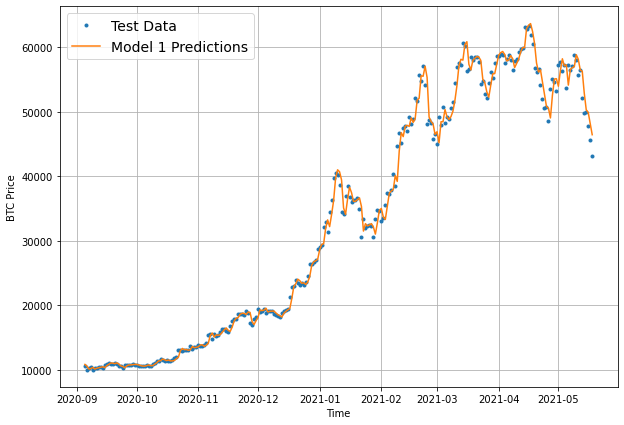

In [42]:
# Plot our model 1 predictions
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="Model 1 Predictions")

## Model 2: Dense model (window = 30, horizon = 1)

(Same as model 1 but different Hypeparameters)

In [43]:
WINDOW_SIZE = 30 # use 30 timesteps in the past
HORIZON = 1 # predict one step at a time (one day of Bitcoin prices)

In [44]:
# Make window data with appropiate horizon and window size
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [45]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
    windows=full_windows,
    labels=full_labels
)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [46]:
train_windows[:3], train_labels[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [47]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct the model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON)
], name="model_2_dense")

# Compile the model
model_2.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_2.fit(
    x = train_windows,
    y = train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name="model_2_name")]
)

Epoch 1/100
15/18 [========================>.....] - ETA: 0s - loss: 2360.6978 - mae: 2360.6978 - mse: 20329444.0000 

18/18 [==============================] - 2s 62ms/step - loss: 2225.0652 - mae: 2225.0652 - mse: 18362778.0000 - val_loss: 3861.2336 - val_mae: 3861.2336 - val_mse: 33459890.0000
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 537.6635 - mae: 537.6635 - mse: 1124164.6250  

18/18 [==============================] - 1s 48ms/step - loss: 537.6635 - mae: 537.6635 - mse: 1124164.6250 - val_loss: 1793.9913 - val_mae: 1793.9913 - val_mse: 8576851.0000
Epoch 3/100
14/18 [======================>.......] - ETA: 0s - loss: 349.8685 - mae: 349.8685 - mse: 530108.6875

18/18 [==============================] - 1s 37ms/step - loss: 335.5531 - mae: 335.5531 - mse: 494132.6562 - val_loss: 1749.3914 - val_mae: 1749.3914 - val_mse: 8249186.5000
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 230.2357 - mae: 230.2357 - mse: 275368.6562

18/18 [==============================] - 1s 49ms/step - loss: 257.5910 - mae: 257.5910 - mse: 305024.8438 - val_loss: 1216.1062 - val_mae: 1216.1062 - val_mse: 4639409.0000
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 239.9384 - mae: 239.9384 - mse: 198104.7344

18/18 [==============================] - 1s 33ms/step - loss: 230.9452 - mae: 230.9452 - mse: 243789.5312 - val_loss: 1124.8602 - val_mae: 1124.8602 - val_mse: 3980124.2500
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 208.2658 - mae: 208.2658 - mse: 211864.2656 - val_loss: 1258.0806 - val_mae: 1258.0806 - val_mse: 4309997.0000
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 201.1627 - mae: 201.1627 - mse: 182862.5000

18/18 [==============================] - 1s 32ms/step - loss: 193.9152 - mae: 193.9152 - mse: 183123.9688 - val_loss: 1018.4330 - val_mae: 1018.4330 - val_mse: 3279358.5000
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 174.7560 - mae: 174.7560 - mse: 147263.5938

18/18 [==============================] - 1s 33ms/step - loss: 183.9360 - mae: 183.9360 - mse: 171472.3281 - val_loss: 991.1689 - val_mae: 991.1689 - val_mse: 3219883.5000
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 190.3997 - mae: 190.3997 - mse: 243098.2031

18/18 [==============================] - 1s 35ms/step - loss: 173.4091 - mae: 173.4091 - mse: 152090.9531 - val_loss: 946.1019 - val_mae: 946.1019 - val_mse: 2915332.7500
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 203.2048 - mae: 203.2048 - mse: 227685.0312

18/18 [==============================] - 1s 33ms/step - loss: 165.6630 - mae: 165.6630 - mse: 142466.9844 - val_loss: 908.0519 - val_mae: 908.0519 - val_mse: 2698077.2500
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 157.4290 - mae: 157.4290 - mse: 118052.7969

18/18 [==============================] - 1s 31ms/step - loss: 161.0058 - mae: 161.0058 - mse: 134213.0000 - val_loss: 896.8399 - val_mae: 896.8399 - val_mse: 2555417.0000
Epoch 12/100
 1/18 [>.............................] - ETA: 0s - loss: 141.4169 - mae: 141.4169 - mse: 107379.9062

18/18 [==============================] - 1s 32ms/step - loss: 155.5631 - mae: 155.5631 - mse: 127859.6094 - val_loss: 866.8417 - val_mae: 866.8417 - val_mse: 2423031.0000
Epoch 13/100
18/18 [==============================] - 0s 5ms/step - loss: 152.2364 - mae: 152.2364 - mse: 122397.4297 - val_loss: 1188.3467 - val_mae: 1188.3467 - val_mse: 4168774.5000
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 273.1493 - mae: 273.1493 - mse: 308341.5000

18/18 [==============================] - 1s 32ms/step - loss: 163.8884 - mae: 163.8884 - mse: 136123.1562 - val_loss: 836.2203 - val_mae: 836.2203 - val_mse: 2301499.0000
Epoch 15/100
18/18 [==============================] - 0s 5ms/step - loss: 152.1788 - mae: 152.1788 - mse: 119551.5312 - val_loss: 924.4124 - val_mae: 924.4124 - val_mse: 2771464.0000
Epoch 16/100
18/18 [==============================] - 0s 5ms/step - loss: 166.5727 - mae: 166.5727 - mse: 132374.1406 - val_loss: 1003.9814 - val_mae: 1003.9814 - val_mse: 3133781.0000
Epoch 17/100
18/18 [==============================] - 0s 13ms/step - loss: 167.3533 - mae: 167.3533 - mse: 129222.4453 - val_loss: 1483.2950 - val_mae: 1483.2950 - val_mse: 5098479.0000
Epoch 18/100
14/18 [======================>.......] - ETA: 0s - loss: 166.1282 - mae: 166.1282 - mse: 130824.1719

18/18 [==============================] - 1s 61ms/step - loss: 164.2085 - mae: 164.2085 - mse: 133758.3438 - val_loss: 813.0516 - val_mae: 813.0516 - val_mse: 2123640.5000
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 121.5184 - mae: 121.5184 - mse: 66454.1328

18/18 [==============================] - 1s 70ms/step - loss: 144.6833 - mae: 144.6833 - mse: 109836.6094 - val_loss: 779.6354 - val_mae: 779.6354 - val_mse: 2011139.0000
Epoch 20/100
18/18 [==============================] - 0s 5ms/step - loss: 141.7601 - mae: 141.7601 - mse: 109654.5000 - val_loss: 895.3958 - val_mae: 895.3958 - val_mse: 2344124.2500
Epoch 21/100
18/18 [==============================] - 0s 7ms/step - loss: 142.0867 - mae: 142.0867 - mse: 105904.4141 - val_loss: 1190.2853 - val_mae: 1190.2853 - val_mse: 3538142.5000
Epoch 22/100
18/18 [==============================] - 0s 19ms/step - loss: 176.1770 - mae: 176.1770 - mse: 134124.9219 - val_loss: 1094.6383 - val_mae: 1094.6383 - val_mse: 3451558.0000
Epoch 23/100
18/18 [==============================] - 0s 10ms/step - loss: 163.5061 - mae: 163.5061 - mse: 121492.6172 - val_loss: 1241.5719 - val_mae: 1241.5719 - val_mse: 3768601.2500
Epoch 24/100
18/18 [==============================] - 0s 9ms/step - loss: 155.9915 - mae:

18/18 [==============================] - 1s 42ms/step - loss: 136.5670 - mae: 136.5670 - mse: 97793.9453 - val_loss: 731.1528 - val_mae: 731.1528 - val_mse: 1790824.7500
Epoch 27/100
18/18 [==============================] - 0s 6ms/step - loss: 133.7432 - mae: 133.7432 - mse: 95053.7578 - val_loss: 821.7999 - val_mae: 821.7999 - val_mse: 2047751.0000
Epoch 28/100
16/18 [=========================>....] - ETA: 0s - loss: 135.6596 - mae: 135.6596 - mse: 95857.2188

18/18 [==============================] - 1s 48ms/step - loss: 136.2878 - mae: 136.2878 - mse: 95747.8906 - val_loss: 727.0277 - val_mae: 727.0277 - val_mse: 1771402.8750
Epoch 29/100
18/18 [==============================] - 0s 6ms/step - loss: 134.6445 - mae: 134.6445 - mse: 96021.6953 - val_loss: 951.7414 - val_mae: 951.7414 - val_mse: 2488658.0000
Epoch 30/100
18/18 [==============================] - 0s 6ms/step - loss: 142.7539 - mae: 142.7539 - mse: 100378.8594 - val_loss: 1130.7047 - val_mae: 1130.7047 - val_mse: 3203061.0000
Epoch 31/100
 1/18 [>.............................] - ETA: 0s - loss: 207.9400 - mae: 207.9400 - mse: 147706.9062

18/18 [==============================] - 1s 48ms/step - loss: 148.7934 - mae: 148.7934 - mse: 111542.3359 - val_loss: 705.9507 - val_mae: 705.9507 - val_mse: 1681469.8750
Epoch 32/100
18/18 [==============================] - 0s 6ms/step - loss: 142.4936 - mae: 142.4936 - mse: 100692.6875 - val_loss: 783.1199 - val_mae: 783.1199 - val_mse: 1896749.6250
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 133.9466 - mae: 133.9466 - mse: 91409.2734 - val_loss: 714.7174 - val_mae: 714.7174 - val_mse: 1700262.0000
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 126.4017 - mae: 126.4017 - mse: 62061.0703

18/18 [==============================] - 1s 52ms/step - loss: 130.2237 - mae: 130.2237 - mse: 89309.5000 - val_loss: 704.6369 - val_mae: 704.6369 - val_mse: 1654527.1250
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 143.9560 - mae: 143.9560 - mse: 185231.0312

18/18 [==============================] - 1s 33ms/step - loss: 126.1173 - mae: 126.1173 - mse: 87406.1875 - val_loss: 695.6470 - val_mae: 695.6470 - val_mse: 1646985.2500
Epoch 36/100
18/18 [==============================] - 0s 4ms/step - loss: 133.9566 - mae: 133.9566 - mse: 92522.2969 - val_loss: 752.4002 - val_mae: 752.4002 - val_mse: 1785641.2500
Epoch 37/100
18/18 [==============================] - 0s 5ms/step - loss: 132.6708 - mae: 132.6708 - mse: 91584.2891 - val_loss: 706.2536 - val_mae: 706.2536 - val_mse: 1635747.2500
Epoch 38/100
18/18 [==============================] - 0s 4ms/step - loss: 136.9128 - mae: 136.9128 - mse: 92796.6875 - val_loss: 728.1723 - val_mae: 728.1723 - val_mse: 1696774.1250
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 134.1304 - mae: 134.1304 - mse: 131227.0156

18/18 [==============================] - 1s 34ms/step - loss: 126.8755 - mae: 126.8755 - mse: 86973.4844 - val_loss: 690.4519 - val_mae: 690.4519 - val_mse: 1587442.3750
Epoch 40/100
18/18 [==============================] - 0s 4ms/step - loss: 130.5353 - mae: 130.5353 - mse: 83795.6641 - val_loss: 728.9113 - val_mae: 728.9113 - val_mse: 1681228.6250
Epoch 41/100
 1/18 [>.............................] - ETA: 0s - loss: 99.1223 - mae: 99.1223 - mse: 31802.8164

18/18 [==============================] - 1s 33ms/step - loss: 128.8434 - mae: 128.8434 - mse: 87002.4922 - val_loss: 676.7067 - val_mae: 676.7067 - val_mse: 1556434.7500
Epoch 42/100
18/18 [==============================] - 0s 5ms/step - loss: 125.2225 - mae: 125.2225 - mse: 83408.8516 - val_loss: 713.4396 - val_mae: 713.4396 - val_mse: 1634388.0000
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 124.9677 - mae: 124.9677 - mse: 84080.5078 - val_loss: 780.4834 - val_mae: 780.4834 - val_mse: 1927852.7500
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 148.8589 - mae: 148.8589 - mse: 113382.1562

18/18 [==============================] - 1s 32ms/step - loss: 134.0790 - mae: 134.0790 - mse: 92967.5469 - val_loss: 664.9693 - val_mae: 664.9693 - val_mse: 1508488.2500
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 121.0889 - mae: 121.0889 - mse: 82163.3203 - val_loss: 697.1229 - val_mae: 697.1229 - val_mse: 1591943.2500
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 121.8817 - mae: 121.8817 - mse: 82173.1719 - val_loss: 688.8928 - val_mae: 688.8928 - val_mse: 1557241.2500
Epoch 47/100
 1/18 [>.............................] - ETA: 0s - loss: 121.8671 - mae: 121.8671 - mse: 51463.9414

18/18 [==============================] - 1s 33ms/step - loss: 122.1458 - mae: 122.1458 - mse: 82352.1016 - val_loss: 657.8870 - val_mae: 657.8870 - val_mse: 1474191.1250
Epoch 48/100
18/18 [==============================] - 0s 4ms/step - loss: 121.3566 - mae: 121.3566 - mse: 80505.9297 - val_loss: 697.1373 - val_mae: 697.1373 - val_mse: 1597081.7500
Epoch 49/100
18/18 [==============================] - 0s 4ms/step - loss: 135.7631 - mae: 135.7631 - mse: 88169.2031 - val_loss: 678.3763 - val_mae: 678.3763 - val_mse: 1527076.0000
Epoch 50/100
18/18 [==============================] - 0s 4ms/step - loss: 140.2485 - mae: 140.2485 - mse: 91935.5078 - val_loss: 1174.4125 - val_mae: 1174.4125 - val_mse: 3565574.5000
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 142.0052 - mae: 142.0052 - mse: 91321.2188 - val_loss: 1141.1791 - val_mae: 1141.1791 - val_mse: 3405624.5000
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 166.1572 - mae: 166.1572

18/18 [==============================] - 1s 47ms/step - loss: 138.4877 - mae: 138.4877 - mse: 92331.5938 - val_loss: 642.3915 - val_mae: 642.3915 - val_mse: 1400380.2500
Epoch 57/100
18/18 [==============================] - 0s 13ms/step - loss: 120.1745 - mae: 120.1745 - mse: 78673.7031 - val_loss: 675.0969 - val_mae: 675.0969 - val_mse: 1486008.7500
Epoch 58/100
18/18 [==============================] - 0s 17ms/step - loss: 124.1465 - mae: 124.1465 - mse: 80885.1094 - val_loss: 707.6469 - val_mae: 707.6469 - val_mse: 1607384.7500
Epoch 59/100
18/18 [==============================] - 0s 25ms/step - loss: 155.6068 - mae: 155.6068 - mse: 106174.8359 - val_loss: 666.6773 - val_mae: 666.6773 - val_mse: 1452627.5000
Epoch 60/100
18/18 [==============================] - 0s 14ms/step - loss: 142.2128 - mae: 142.2128 - mse: 93211.4844 - val_loss: 916.5371 - val_mae: 916.5371 - val_mse: 2247592.0000
Epoch 61/100
14/18 [======================>.......] - ETA: 0s - loss: 131.5537 - mae: 131.5537 - 

18/18 [==============================] - 1s 78ms/step - loss: 130.0070 - mae: 130.0070 - mse: 84751.9766 - val_loss: 639.7845 - val_mae: 639.7845 - val_mse: 1388533.1250
Epoch 62/100
18/18 [==============================] - 0s 6ms/step - loss: 120.7627 - mae: 120.7627 - mse: 80918.5078 - val_loss: 685.4915 - val_mae: 685.4915 - val_mse: 1540287.1250
Epoch 63/100
18/18 [==============================] - 0s 4ms/step - loss: 122.1754 - mae: 122.1754 - mse: 79435.8750 - val_loss: 659.1092 - val_mae: 659.1092 - val_mse: 1427905.1250
Epoch 64/100
18/18 [==============================] - 0s 4ms/step - loss: 116.4447 - mae: 116.4447 - mse: 75940.3750 - val_loss: 666.4490 - val_mae: 666.4490 - val_mse: 1453032.5000
Epoch 65/100
13/18 [====================>.........] - ETA: 0s - loss: 121.0416 - mae: 121.0416 - mse: 77922.6562

18/18 [==============================] - 1s 56ms/step - loss: 120.2349 - mae: 120.2349 - mse: 78893.6875 - val_loss: 627.8129 - val_mae: 627.8129 - val_mse: 1354308.0000
Epoch 66/100
18/18 [==============================] - 0s 8ms/step - loss: 116.0254 - mae: 116.0254 - mse: 75903.3594 - val_loss: 634.0924 - val_mae: 634.0924 - val_mse: 1381398.2500
Epoch 67/100
18/18 [==============================] - 0s 9ms/step - loss: 121.0704 - mae: 121.0704 - mse: 79467.0234 - val_loss: 640.7568 - val_mae: 640.7568 - val_mse: 1402909.6250
Epoch 68/100
18/18 [==============================] - 0s 9ms/step - loss: 126.1973 - mae: 126.1973 - mse: 81985.2969 - val_loss: 641.0960 - val_mae: 641.0960 - val_mse: 1384645.8750
Epoch 69/100
18/18 [==============================] - 0s 15ms/step - loss: 126.5239 - mae: 126.5239 - mse: 82694.7656 - val_loss: 685.0554 - val_mae: 685.0554 - val_mse: 1487064.3750
Epoch 70/100
18/18 [==============================] - 0s 7ms/step - loss: 122.9944 - mae: 122.9944 - 

18/18 [==============================] - 2s 114ms/step - loss: 120.5563 - mae: 120.5563 - mse: 79526.2109 - val_loss: 621.2504 - val_mae: 621.2504 - val_mse: 1324749.5000
Epoch 73/100
18/18 [==============================] - 0s 12ms/step - loss: 117.3117 - mae: 117.3117 - mse: 76740.3438 - val_loss: 638.9326 - val_mae: 638.9326 - val_mse: 1368060.3750
Epoch 74/100
18/18 [==============================] - 0s 7ms/step - loss: 120.3628 - mae: 120.3628 - mse: 78470.6875 - val_loss: 622.4446 - val_mae: 622.4446 - val_mse: 1328361.0000
Epoch 75/100
18/18 [==============================] - 0s 4ms/step - loss: 139.5344 - mae: 139.5344 - mse: 91384.4375 - val_loss: 655.7564 - val_mae: 655.7564 - val_mse: 1410952.8750
Epoch 76/100
18/18 [==============================] - 0s 6ms/step - loss: 142.7335 - mae: 142.7335 - mse: 92559.5312 - val_loss: 686.9679 - val_mae: 686.9679 - val_mse: 1503690.2500
Epoch 77/100
18/18 [==============================] - 0s 12ms/step - loss: 132.5261 - mae: 132.5261 

18/18 [==============================] - 1s 87ms/step - loss: 135.3547 - mae: 135.3547 - mse: 90489.1797 - val_loss: 609.9199 - val_mae: 609.9199 - val_mse: 1285303.7500
Epoch 86/100
18/18 [==============================] - 0s 9ms/step - loss: 114.8518 - mae: 114.8518 - mse: 73643.8438 - val_loss: 692.3904 - val_mae: 692.3904 - val_mse: 1497962.0000
Epoch 87/100
18/18 [==============================] - 0s 9ms/step - loss: 122.4602 - mae: 122.4602 - mse: 79320.7109 - val_loss: 624.2453 - val_mae: 624.2453 - val_mse: 1322980.8750
Epoch 88/100
18/18 [==============================] - 0s 17ms/step - loss: 119.8543 - mae: 119.8543 - mse: 77489.8516 - val_loss: 1001.1585 - val_mae: 1001.1585 - val_mse: 2494526.5000
Epoch 89/100
18/18 [==============================] - 0s 15ms/step - loss: 139.1090 - mae: 139.1090 - mse: 94979.1406 - val_loss: 1308.1943 - val_mae: 1308.1943 - val_mse: 3811923.7500
Epoch 90/100
18/18 [==============================] - 0s 21ms/step - loss: 152.7396 - mae: 152.7

In [48]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 622.7374 - mae: 622.7374 - mse: 1322727.8750


[622.7374267578125, 622.7374267578125, 1322727.875]

In [49]:
# Load in the best performing model
model_2 = tf.keras.models.load_model("/content/model_experiments/model_2_name")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 609.9197 - mae: 609.9197 - mse: 1285303.6250


[609.9197387695312, 609.9197387695312, 1285303.625]

In [50]:
# Get the forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 2ms/step


In [51]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),
    y_pred=model_2_preds
)
model_2_results

{'mae': 609.9195844536399,
 'mse': 1285303.4190886111,
 'rmse': 1133.7122293988944,
 'mape': 2.7827711642985276,
 'mase': 1.0661453293286085}

In [52]:
model_1_results

{'mae': 566.8767172625165,
 'mse': 1170221.4316556733,
 'rmse': 1081.7677346157416,
 'mape': 2.5472506786440356,
 'mase': 0.9958452777902369}

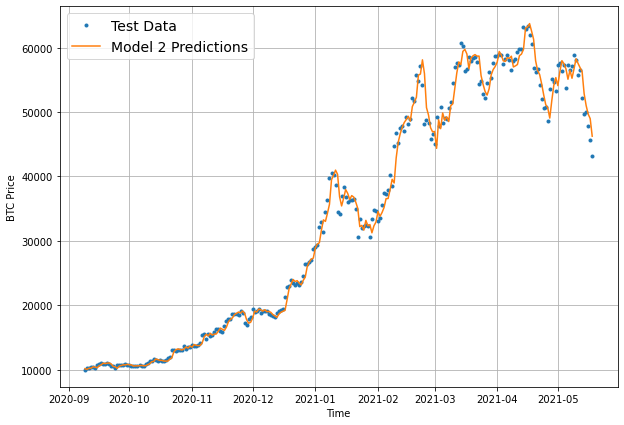

In [53]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="Model 2 Predictions")

## Model 3: Dense (window = 30, horizon = 7)

(Same as model 1 but different Hypeparameters)

In [54]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [55]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
    windows = full_windows,
    labels = full_labels
)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [56]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct the model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON)
], name="model_3_dense")

# Compile the model
model_3.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_3.fit(
    x = train_windows,
    y = train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name="model_3_name")]
)

Epoch 1/100
 1/18 [>.............................] - ETA: 10s - loss: 3747.4478 - mae: 3747.4478 - mse: 45819552.0000

18/18 [==============================] - 1s 44ms/step - loss: 1661.1161 - mae: 1661.1161 - mse: 13613648.0000 - val_loss: 3113.1025 - val_mae: 3113.1025 - val_mse: 24430410.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 501.1721 - mae: 501.1721 - mse: 1032139.8750

18/18 [==============================] - 1s 51ms/step - loss: 567.7487 - mae: 567.7487 - mse: 1505306.6250 - val_loss: 2877.0217 - val_mae: 2877.0217 - val_mse: 24765268.0000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 442.6339 - mae: 442.6339 - mse: 724184.8750

18/18 [==============================] - 1s 34ms/step - loss: 456.6006 - mae: 456.6006 - mse: 1046822.6250 - val_loss: 2358.4036 - val_mae: 2358.4036 - val_mse: 16629806.0000
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 490.8745 - mae: 490.8745 - mse: 1181430.0000

18/18 [==============================] - 1s 33ms/step - loss: 412.0361 - mae: 412.0361 - mse: 862962.8125 - val_loss: 2120.9070 - val_mae: 2120.9070 - val_mse: 13634777.0000
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 453.6616 - mae: 453.6616 - mse: 1228783.7500

18/18 [==============================] - 1s 33ms/step - loss: 381.1122 - mae: 381.1122 - mse: 745422.1875 - val_loss: 2098.5486 - val_mae: 2098.5486 - val_mse: 13275604.0000
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 308.1485 - mae: 308.1485 - mse: 437185.8750

18/18 [==============================] - 1s 33ms/step - loss: 358.2979 - mae: 358.2979 - mse: 649234.1875 - val_loss: 1963.6937 - val_mae: 1963.6937 - val_mse: 11648712.0000
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 301.8198 - mae: 301.8198 - mse: 502067.2500

18/18 [==============================] - 1s 33ms/step - loss: 331.9355 - mae: 331.9355 - mse: 559223.9375 - val_loss: 1724.2817 - val_mae: 1724.2817 - val_mse: 9239830.0000
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 283.0038 - mae: 283.0038 - mse: 419641.3125

18/18 [==============================] - 1s 32ms/step - loss: 316.8061 - mae: 316.8061 - mse: 501914.9375 - val_loss: 1652.2634 - val_mae: 1652.2634 - val_mse: 8560562.0000
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 306.2162 - mae: 306.2162 - mse: 469180.6562 - val_loss: 1769.1731 - val_mae: 1769.1731 - val_mse: 9190890.0000
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 250.5117 - mae: 250.5117 - mse: 261405.4688

18/18 [==============================] - 1s 31ms/step - loss: 303.2002 - mae: 303.2002 - mse: 443167.1250 - val_loss: 1571.9701 - val_mae: 1571.9701 - val_mse: 7755038.0000
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 302.9277 - mae: 302.9277 - mse: 477765.1250

18/18 [==============================] - 1s 33ms/step - loss: 290.0938 - mae: 290.0938 - mse: 416201.4375 - val_loss: 1524.2334 - val_mae: 1524.2334 - val_mse: 7532188.0000
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 282.4759 - mae: 282.4759 - mse: 401787.8438 - val_loss: 1691.6942 - val_mae: 1691.6942 - val_mse: 8589416.0000
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 261.6370 - mae: 261.6370 - mse: 357776.7812

18/18 [==============================] - 1s 47ms/step - loss: 279.8545 - mae: 279.8545 - mse: 391067.7500 - val_loss: 1482.7460 - val_mae: 1482.7460 - val_mse: 7197671.0000
Epoch 14/100
18/18 [==============================] - 0s 7ms/step - loss: 274.8026 - mae: 274.8026 - mse: 383060.5625 - val_loss: 1488.4821 - val_mae: 1488.4821 - val_mse: 7203516.5000
Epoch 15/100
18/18 [==============================] - 0s 7ms/step - loss: 274.5158 - mae: 274.5158 - mse: 383667.4062 - val_loss: 1618.0399 - val_mae: 1618.0399 - val_mse: 7819794.5000
Epoch 16/100
18/18 [==============================] - 0s 7ms/step - loss: 270.8719 - mae: 270.8719 - mse: 371656.4375 - val_loss: 1517.0022 - val_mae: 1517.0022 - val_mse: 7181377.0000
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 268.4751 - mae: 268.4751 - mse: 368989.1562 - val_loss: 1685.5782 - val_mae: 1685.5782 - val_mse: 8391957.0000
Epoch 18/100
18/18 [==============================] - 0s 8ms/step - loss: 269.8760 - ma

18/18 [==============================] - 1s 48ms/step - loss: 267.5828 - mae: 267.5828 - mse: 360860.3750 - val_loss: 1432.7913 - val_mae: 1432.7913 - val_mse: 6757786.5000
Epoch 21/100
18/18 [==============================] - 0s 6ms/step - loss: 259.1620 - mae: 259.1620 - mse: 345288.4688 - val_loss: 1514.0190 - val_mae: 1514.0190 - val_mse: 7142723.5000
Epoch 22/100
16/18 [=========================>....] - ETA: 0s - loss: 258.3806 - mae: 258.3806 - mse: 343682.8125

18/18 [==============================] - 1s 38ms/step - loss: 258.2939 - mae: 258.2939 - mse: 341614.0312 - val_loss: 1404.7614 - val_mae: 1404.7614 - val_mse: 6537019.0000
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 280.0797 - mae: 280.0797 - mse: 520685.7188

18/18 [==============================] - 1s 32ms/step - loss: 257.7587 - mae: 257.7587 - mse: 341860.0625 - val_loss: 1397.3096 - val_mae: 1397.3096 - val_mse: 6494785.0000
Epoch 24/100
18/18 [==============================] - 0s 4ms/step - loss: 274.7592 - mae: 274.7592 - mse: 371417.2188 - val_loss: 1430.5923 - val_mae: 1430.5923 - val_mse: 6704749.5000
Epoch 25/100
18/18 [==============================] - 0s 5ms/step - loss: 258.4378 - mae: 258.4378 - mse: 340085.0000 - val_loss: 1567.2191 - val_mae: 1567.2191 - val_mse: 7401732.5000
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 255.2192 - mae: 255.2192 - mse: 325374.9688

18/18 [==============================] - 1s 33ms/step - loss: 256.6958 - mae: 256.6958 - mse: 334970.8750 - val_loss: 1389.6422 - val_mae: 1389.6422 - val_mse: 6374304.5000
Epoch 27/100
18/18 [==============================] - 0s 5ms/step - loss: 251.5311 - mae: 251.5311 - mse: 329188.0000 - val_loss: 1406.5320 - val_mae: 1406.5320 - val_mse: 6403096.0000
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 222.3370 - mae: 222.3370 - mse: 249983.4688

18/18 [==============================] - 1s 34ms/step - loss: 252.9551 - mae: 252.9551 - mse: 327036.7188 - val_loss: 1387.9282 - val_mae: 1387.9282 - val_mse: 6340725.5000
Epoch 29/100
18/18 [==============================] - 0s 5ms/step - loss: 249.7239 - mae: 249.7239 - mse: 324110.4062 - val_loss: 1391.7142 - val_mae: 1391.7142 - val_mse: 6343568.0000
Epoch 30/100
18/18 [==============================] - 0s 4ms/step - loss: 251.7651 - mae: 251.7651 - mse: 331016.8750 - val_loss: 1407.0098 - val_mae: 1407.0098 - val_mse: 6484473.0000
Epoch 31/100
 1/18 [>.............................] - ETA: 0s - loss: 207.8910 - mae: 207.8910 - mse: 248157.6094

18/18 [==============================] - 1s 53ms/step - loss: 247.8464 - mae: 247.8464 - mse: 317817.7188 - val_loss: 1387.0923 - val_mae: 1387.0923 - val_mse: 6325881.5000
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 240.3791 - mae: 240.3791 - mse: 232031.2188

18/18 [==============================] - 1s 37ms/step - loss: 248.9384 - mae: 248.9384 - mse: 320903.1250 - val_loss: 1339.7296 - val_mae: 1339.7296 - val_mse: 6083134.5000
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 250.1818 - mae: 250.1818 - mse: 323732.5625 - val_loss: 1428.1082 - val_mae: 1428.1082 - val_mse: 6585847.5000
Epoch 34/100
18/18 [==============================] - 0s 5ms/step - loss: 246.6769 - mae: 246.6769 - mse: 317498.4375 - val_loss: 1423.6447 - val_mae: 1423.6447 - val_mse: 6514050.0000
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 245.7373 - mae: 245.7373 - mse: 314426.6250 - val_loss: 1375.6460 - val_mae: 1375.6460 - val_mse: 6213181.0000
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 244.7825 - mae: 244.7825 - mse: 315474.2188 - val_loss: 1438.9768 - val_mae: 1438.9768 - val_mse: 6693340.5000
Epoch 37/100
18/18 [==============================] - 0s 5ms/step - loss: 264.2002 - ma

18/18 [==============================] - 1s 32ms/step - loss: 241.4932 - mae: 241.4932 - mse: 305422.1250 - val_loss: 1331.1549 - val_mae: 1331.1549 - val_mse: 6052030.0000
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 245.7579 - mae: 245.7579 - mse: 311653.3438 - val_loss: 1340.1724 - val_mae: 1340.1724 - val_mse: 6002090.5000
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 244.5084 - mae: 244.5084 - mse: 309635.2188 - val_loss: 1610.2520 - val_mae: 1610.2520 - val_mse: 7331515.0000
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 250.2643 - mae: 250.2643 - mse: 317682.9062 - val_loss: 1362.8938 - val_mae: 1362.8938 - val_mse: 6105877.0000
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 241.6432 - mae: 241.6432 - mse: 305363.7500 - val_loss: 1383.3057 - val_mae: 1383.3057 - val_mse: 6230702.5000
Epoch 48/100
 1/18 [>.............................] - ETA: 0s - loss: 265.0490 - mae: 2

18/18 [==============================] - 1s 32ms/step - loss: 240.3950 - mae: 240.3950 - mse: 301632.7500 - val_loss: 1309.9552 - val_mae: 1309.9552 - val_mse: 5801981.0000
Epoch 49/100
18/18 [==============================] - 0s 6ms/step - loss: 247.8764 - mae: 247.8764 - mse: 307677.4375 - val_loss: 1408.4823 - val_mae: 1408.4823 - val_mse: 6376455.5000
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 241.2692 - mae: 241.2692 - mse: 303432.8438 - val_loss: 1339.4006 - val_mae: 1339.4006 - val_mse: 5946633.5000
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 239.7976 - mae: 239.7976 - mse: 294696.9688 - val_loss: 1405.2622 - val_mae: 1405.2622 - val_mse: 6283441.0000
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 234.9259 - mae: 234.9259 - mse: 291979.1250 - val_loss: 1339.8136 - val_mae: 1339.8136 - val_mse: 5920725.0000
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 235.7258 - ma

18/18 [==============================] - 1s 31ms/step - loss: 238.2914 - mae: 238.2914 - mse: 296348.3750 - val_loss: 1303.7887 - val_mae: 1303.7887 - val_mse: 5736010.5000
Epoch 55/100
18/18 [==============================] - 0s 4ms/step - loss: 232.9212 - mae: 232.9212 - mse: 287818.8438 - val_loss: 1341.4333 - val_mae: 1341.4333 - val_mse: 5917661.0000
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 236.8119 - mae: 236.8119 - mse: 295647.3438 - val_loss: 1346.3419 - val_mae: 1346.3419 - val_mse: 5907969.0000
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 238.0856 - mae: 238.0856 - mse: 296697.6875 - val_loss: 1363.6669 - val_mae: 1363.6669 - val_mse: 6051923.5000
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 235.4958 - mae: 235.4958 - mse: 292465.9688 - val_loss: 1312.2446 - val_mae: 1312.2446 - val_mse: 5800022.5000
Epoch 59/100
18/18 [==============================] - 0s 6ms/step - loss: 234.2453 - ma

18/18 [==============================] - 1s 33ms/step - loss: 240.6454 - mae: 240.6454 - mse: 299616.6250 - val_loss: 1296.2749 - val_mae: 1296.2749 - val_mse: 5704399.0000
Epoch 61/100
18/18 [==============================] - 0s 6ms/step - loss: 235.2779 - mae: 235.2779 - mse: 289788.9688 - val_loss: 1442.5341 - val_mae: 1442.5341 - val_mse: 6459610.5000
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 237.9082 - mae: 237.9082 - mse: 294804.9688 - val_loss: 1296.8047 - val_mae: 1296.8047 - val_mse: 5761259.0000
Epoch 63/100
18/18 [==============================] - 0s 4ms/step - loss: 236.7439 - mae: 236.7439 - mse: 293051.4375 - val_loss: 1405.4719 - val_mae: 1405.4719 - val_mse: 6370153.5000
Epoch 64/100
 1/18 [>.............................] - ETA: 0s - loss: 255.1123 - mae: 255.1123 - mse: 266631.2500

18/18 [==============================] - 1s 32ms/step - loss: 234.6171 - mae: 234.6171 - mse: 291815.2188 - val_loss: 1268.6021 - val_mae: 1268.6021 - val_mse: 5568983.5000
Epoch 65/100
18/18 [==============================] - 0s 4ms/step - loss: 235.5608 - mae: 235.5608 - mse: 295270.5000 - val_loss: 1352.5121 - val_mae: 1352.5121 - val_mse: 5841306.5000
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 233.1368 - mae: 233.1368 - mse: 287439.4688 - val_loss: 1537.0560 - val_mae: 1537.0560 - val_mse: 6964949.5000
Epoch 67/100
18/18 [==============================] - 0s 4ms/step - loss: 242.6186 - mae: 242.6186 - mse: 300427.6875 - val_loss: 1286.4736 - val_mae: 1286.4736 - val_mse: 5584499.0000
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 243.8605 - mae: 243.8605 - mse: 298751.6250 - val_loss: 1291.7196 - val_mae: 1291.7196 - val_mse: 5609365.0000
Epoch 69/100
18/18 [==============================] - 0s 7ms/step - loss: 231.5437 - ma

18/18 [==============================] - 1s 32ms/step - loss: 226.1724 - mae: 226.1724 - mse: 274767.1875 - val_loss: 1242.8704 - val_mae: 1242.8704 - val_mse: 5422366.0000
Epoch 93/100
18/18 [==============================] - 0s 4ms/step - loss: 227.5160 - mae: 227.5160 - mse: 277293.4375 - val_loss: 1355.3116 - val_mae: 1355.3116 - val_mse: 5862615.0000
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 229.3794 - mae: 229.3794 - mse: 278487.2188 - val_loss: 1289.0012 - val_mae: 1289.0012 - val_mse: 5580883.5000
Epoch 95/100
18/18 [==============================] - 0s 4ms/step - loss: 225.9289 - mae: 225.9289 - mse: 273354.3750 - val_loss: 1259.0767 - val_mae: 1259.0767 - val_mse: 5489727.0000
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 231.0697 - mae: 231.0697 - mse: 281599.3438 - val_loss: 1359.2836 - val_mae: 1359.2836 - val_mse: 5890549.0000
Epoch 97/100
18/18 [==============================] - 0s 4ms/step - loss: 223.0295 - ma

In [57]:
# Evaluate model 2 on test data
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1473.4294 - mae: 1473.4294 - mse: 6490557.5000


[1473.429443359375, 1473.429443359375, 6490557.5]

In [58]:
# Load in the best performing model
model_3 = tf.keras.models.load_model("/content/model_experiments/model_3_name")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1242.8704 - mae: 1242.8704 - mse: 5422366.0000


[1242.870361328125, 1242.870361328125, 5422366.0]

In [59]:
# Get the forecasting predictions for model 3
model_3_preds = make_preds(model_3,
                           input_data=test_windows)

18/18 [==============================] - 0s 1ms/step


In [60]:
# Evaluate results for model 3 predictions
model_3_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),
    y_pred=model_3_preds
)
model_3_results

{'mae': 1242.8703315454163,
 'mse': 5422365.911292289,
 'rmse': 1424.4058172028956,
 'mape': 5.544131766843307,
 'mase': 2.2116180904980185}

In [61]:
model_1_results, model_2_results

({'mae': 566.8767172625165,
  'mse': 1170221.4316556733,
  'rmse': 1081.7677346157416,
  'mape': 2.5472506786440356,
  'mase': 0.9958452777902369},
 {'mae': 609.9195844536399,
  'mse': 1285303.4190886111,
  'rmse': 1133.7122293988944,
  'mape': 2.7827711642985276,
  'mase': 1.0661453293286085})

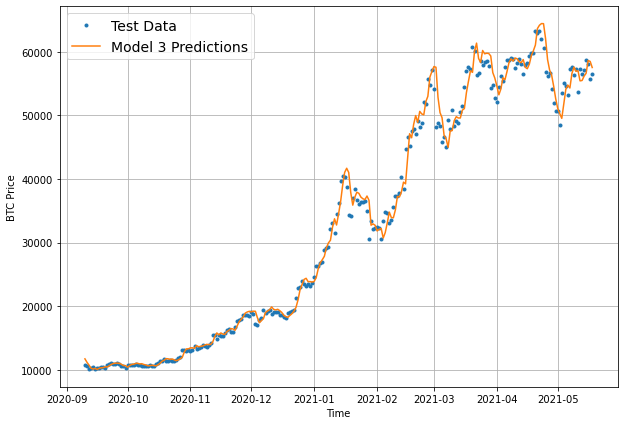

In [62]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=offset, format="-", label="Model 3 Predictions")

## Comparing the models build so far to see how well they performed

<Axes: >

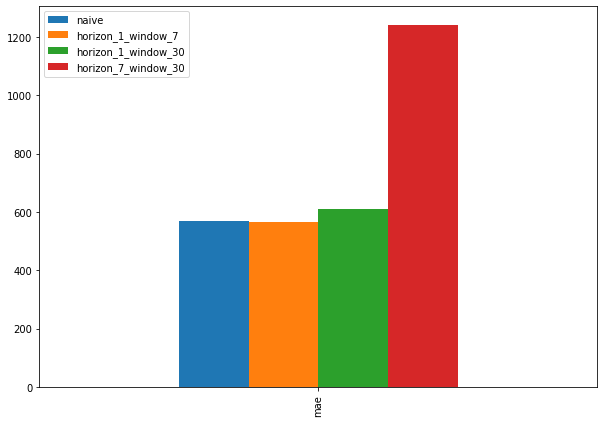

In [63]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]
              }, index=["mae"]).plot(figsize=(10, 7), kind="bar")

Note: You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at t+1 (the next timestep) is typically close to the value at t (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naïve model will often get fairly good results.

## Model 4: Conv1D

In [64]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

In [66]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [68]:
# Create train/test sets
train_windows, test_windows, train_labels, test_windows = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 551)

We need an input shape of: `(batch_size, timesteps, input_dim)`...

However the data isn't in that shape yet

In [70]:
# Check data input shape
train_windows[0].shape # returns (WINDOWS_SIZE, )

(7,)

In [69]:
# Before I pass the data to the Conv1D layer, I will need to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [72]:
expand_dims_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an exate dimension for input dim

In [75]:
# Test the lambda layer
print(f"Original shape: {x.shape}") # (WINDOW_SIZE, )
print(f"Expanded shape: {expand_dims_layer(x).shape}") # output =  (WINDOW_SIZE, HORIZON)
print(f"Original values with expanded shape: \n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape: 
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]
